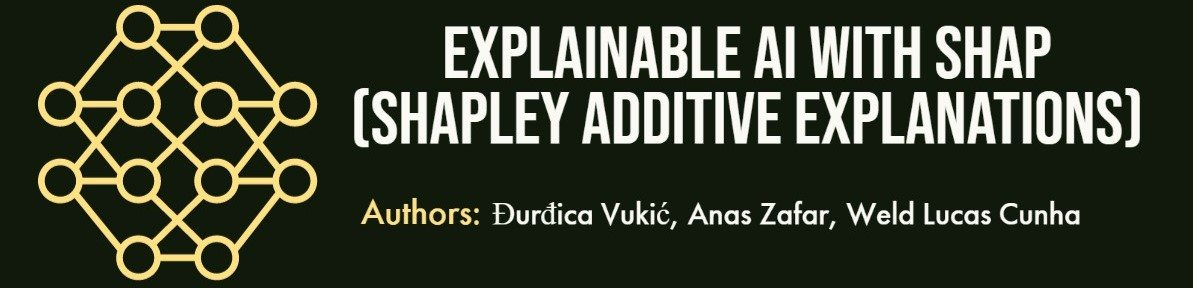

<a href="https://colab.research.google.com/github/mathysgrapotte/deepexplain/blob/main/Revised_v3_04_shapley_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable AI with SHAP (SHapley Additive exPlanations)**


The goal of **SHAP** is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes **Shapley values** from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features. A player can be an individual feature value, e.g. for tabular data [Example 1 below]. A player can also be a group of feature values. For example to explain an image, pixels can be grouped to superpixels and the prediction distributed among them [Example 2 below][7].


 
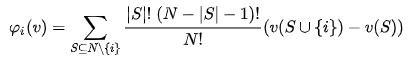



Shapley establishes the following four Axioms in order to achieve a fair contribution[19]:
* **Axiom 1**: Efficiency. The sum of the Shapley values of all agents equals the value of the total coalition.
* **Axiom 2**: Symmetry. All players have a fair chance to join the game. That’s why Table A above lists all the permutations of the players. In case two players add the same gain to every possible coalition then they should have the same contribution.
* **Axiom 3**: Dummy. If player i contributes nothing to any coalition S, then the contribution of Player i is zero, i.e. , φᵢ(v)=0. Obviously we need to set the boundary value.
* **Axiom 4**: Additivity. For any pair of games v, w: φ(v+w)=φ(v)+φ(w), where (v+w)(S)=v(S)+w(S) for all S. This property enables us to do the simple arithmetic summation.

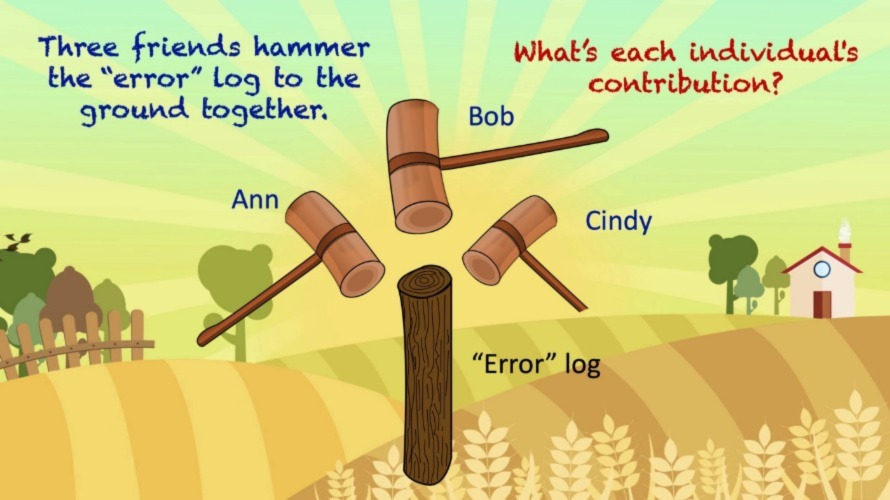

<h3 align="center">Figure 1: SHAP Real Life Example</h3> 

This tutorial is designed to help build a basic understanding of how to compute and interpret Shapley-based explanations on deep learning model using the SHAP Python package.
 

##Pipeline Of Explainable Tool SHAP




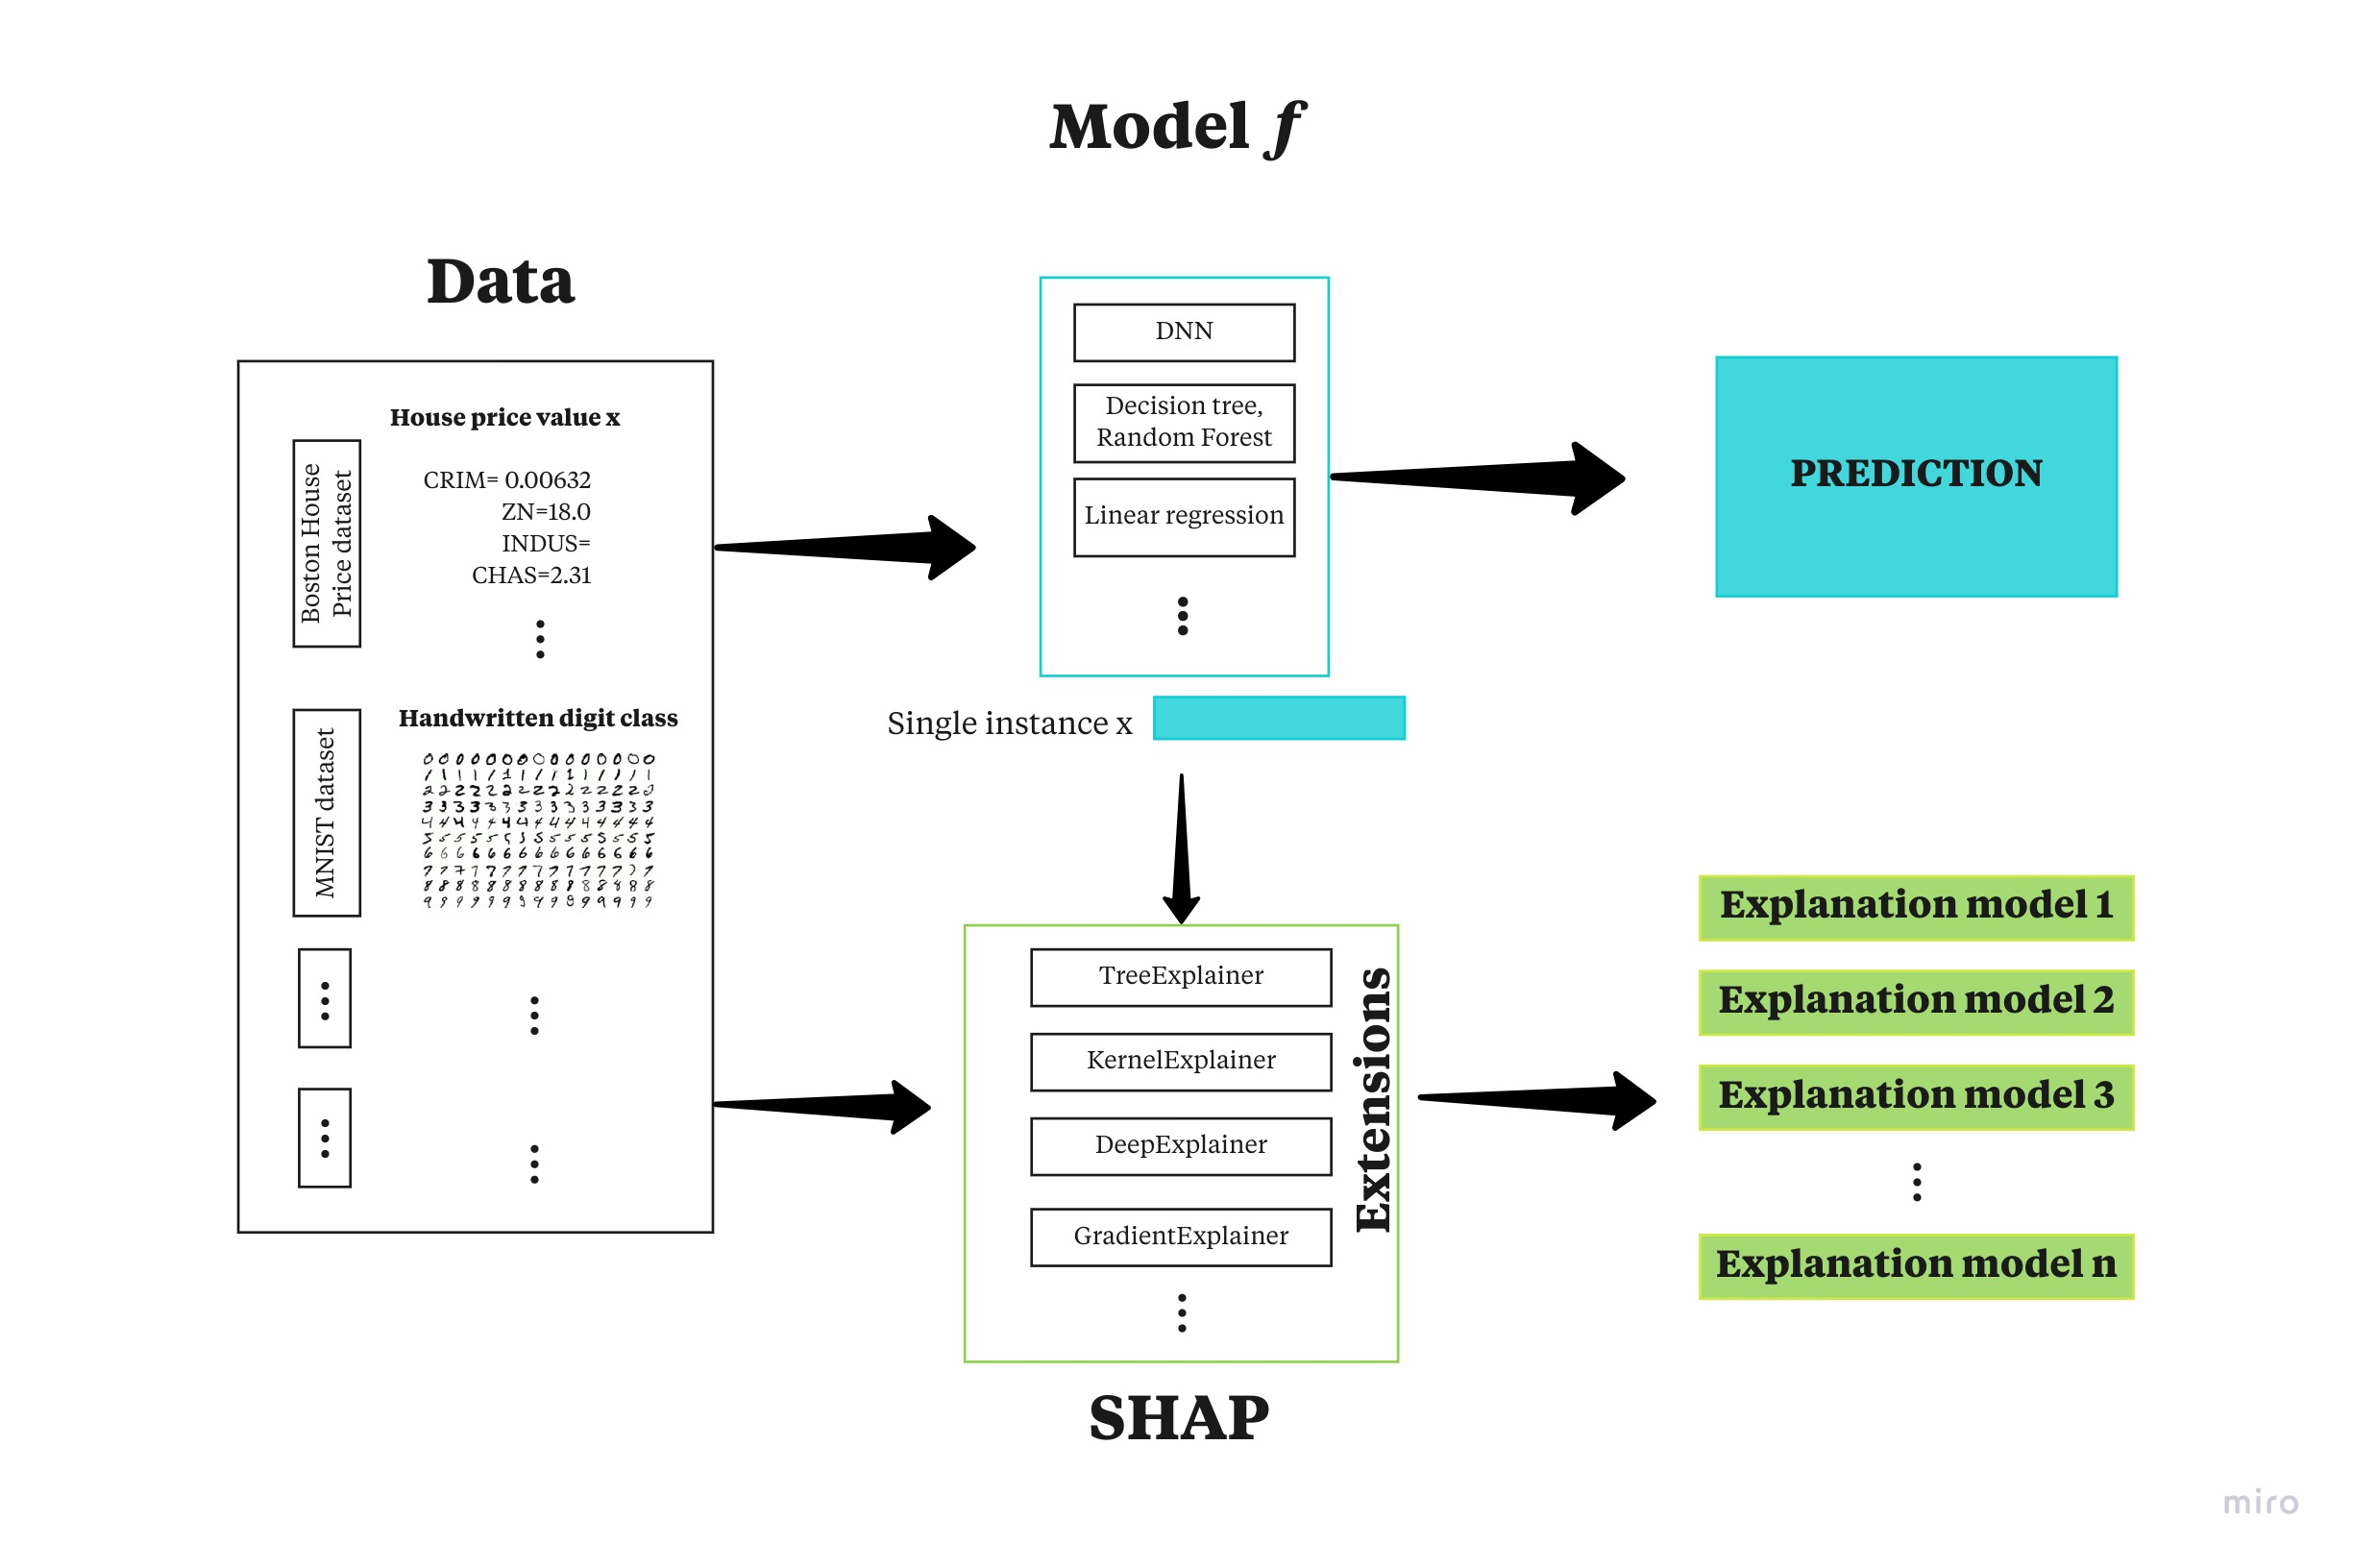

<h3 align="center">Figure 2: SHAP Pipeline</h3>


In the model agnostic explainer, SHAP leverages Shapley values in the below manner. To get the importance of feature X{i} [13]:

*  Get all subsets of features S that do not contain X{i}
*  Compute effect on our predictions of adding X{i} to all those subsets
*  Aggregate all contributions to compute the marginal contribution of the feature

Now, for these subsets, SHAP does not go on and retrain the model for each subset. Instead, for the removed or left out feature, it just replaces it with the average value of the feature and generates the predictions.



In **context of ML models**, the players of this cooperative game are replaced by the features of the ML model and the payoff by the model output itself. Let’s return to our Boston housing dataset example to make this clearer. Suppose we have a model that is trained to predict the monetary value of a house located at the Boston's area. For example House   price is predicted as $72 000, and we want to understand how important is **CRIM-per capita crime rate by town**(which happens to be feature i) was in determining the model’s decision. We first would pick a random subset of features S to provide to the model. For example, S could include **TAX:** full-value property-tax rate per 10,000 USD and **DIS:** weighted distances to five Boston employment centres. We would then measure the marginal contribution v(S ∪ {i})-v(S) which tells us how much the inclusion of CRIM to the model (feature i) changes the model’s output relative to the model’s output with TAX and DIS as the only features. In other words, **the marginal contribution captures the incremental contribution of CRIM to the model’s output while accounting for its interaction with the TAX and DIS features**. The Shapley value is the weighted average of all such marginal contributions over varying S.
  














**CORE *SHAP* EXTENSIONS** [16]: 

*   **TreeExplainer** - high speed exact algorithm for tree ensembles
*   **DeepExplainer** - high speed approximation algorithm for chef values in deep learning models
*   **GradientExplainer** -combines ideas from Integrated Gradients, Shap and SmoothGrad into a single expected value equation 
*   **KernelExplainer**- uses specially-weighted local linear regression to estimate Shap values for any model



## **Example 1 - Boston Housing dataset**
### About the Dataset
We will be working on a data set that comes from the real estate industry in Boston (US)[17]. This database contains 14 attributes. The target variable refers to the median value of owner-occupied homes in 1000 USD's.

* CRIM: per capita crime rate by town
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per 10,000 USD
* PTRATIO: pupil-teacher ratio by town
* B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT: lower status of the population (%)
* MEDV: Median value of owner-occupied homes in 1000 USD's (Target)


In [44]:
# setup
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import Sequential    
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
#@title
def create_model(n_features):
        # define the model
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_features,)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    
    return model

def train(X_train,y_train,epochs):
    n_features = X_train.shape[1]
    model = create_model(n_features)
    # Compile the model:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.metrics.mean_squared_error
       
    model.compile(optimizer=optimizer, loss=loss)
    # model training
    callbacks = [EarlyStopping(monitor='val_loss', mode='min',
                           patience=10,
                           restore_best_weights=True)]
    #model fit
    model.fit(X_train, y_train,
          shuffle=True,
          callbacks=callbacks,
          epochs=epochs, validation_split=0.2)
    
    return model



###Loading Data

In [46]:
def load_boston():
    
    '''
    load Boston housing dataset from the original CMU source - code used from official sklearn docs

    we have to make this workaround to ensure that we have the data on colab AND we do not get deprecation issues in the future 
    (Boston Housing is going to be deprecated due to ethical issues, see sklearn docs)
    
    '''
    columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT', 'PRICE']

    import pandas as pd  # doctest: +SKIP
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])

    _dat=[[float(val) for val in row[0].split()]+[float(val) for val in row[1].split()] for row in data]
    clean=pd.DataFrame(_dat)

    clean.columns=columns

    return clean


In [47]:
data=load_boston()

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [49]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [50]:
data.sample(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
255,0.03548,80.0,3.64,0.0,0.392,5.876,19.1,9.2203,1.0,315.0,16.4,395.18,9.25,20.9
77,0.08707,0.0,12.83,0.0,0.437,6.140,45.8,4.0905,5.0,398.0,18.7,386.96,10.27,20.8
63,0.12650,25.0,5.13,0.0,0.453,6.762,43.4,7.9809,8.0,284.0,19.7,395.58,9.50,25.0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
146,2.15505,0.0,19.58,0.0,0.871,5.628,100.0,1.5166,5.0,403.0,14.7,169.27,16.65,15.6


### Data Preparation

In [51]:
# Here we will split data into X and y
X = data.drop('PRICE', axis=1)
y = data['PRICE']

In [52]:
# Use the function train_test_split( ) to split our data into two sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
print('Train data:', X_train.shape)
print('Test data:', X_test.shape)

Train data: (354, 13)
Test data: (152, 13)


In [54]:
def plot_model_hist(hist, feat='loss', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.plot(hist.index, hist[f'{feat}'], label='train')
    plt.plot(hist.index, hist[f'val_{feat}'], label='valid')
    plt.xlabel('epoch')
    plt.ylabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

###Model Training

In [55]:
model=train(X_train, y_train, 50)

Train on 283 samples, validate on 71 samples
Epoch 1/50
283/283 [==============================] - 0s 1ms/sample - loss: 6535.8660 - val_loss: 4470.9661
Epoch 2/50
283/283 [==============================] - 0s 94us/sample - loss: 4136.5453 - val_loss: 2892.7516
Epoch 3/50
283/283 [==============================] - 0s 94us/sample - loss: 2839.8099 - val_loss: 2017.6705
Epoch 4/50
283/283 [==============================] - 0s 115us/sample - loss: 2135.4811 - val_loss: 1580.3989
Epoch 5/50
 32/283 [==>...........................] - ETA: 0s - loss: 2134.4536

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


283/283 [==============================] - 0s 101us/sample - loss: 1744.8800 - val_loss: 1332.8320
Epoch 6/50
283/283 [==============================] - 0s 92us/sample - loss: 1476.8835 - val_loss: 1145.0118
Epoch 7/50
283/283 [==============================] - 0s 84us/sample - loss: 1275.1166 - val_loss: 981.9726
Epoch 8/50
283/283 [==============================] - 0s 88us/sample - loss: 1104.8620 - val_loss: 846.8525
Epoch 9/50
283/283 [==============================] - 0s 90us/sample - loss: 956.0692 - val_loss: 724.8210
Epoch 10/50
283/283 [==============================] - 0s 121us/sample - loss: 811.3610 - val_loss: 595.7032
Epoch 11/50
283/283 [==============================] - 0s 86us/sample - loss: 674.9349 - val_loss: 482.2366
Epoch 12/50
283/283 [==============================] - 0s 87us/sample - loss: 549.9875 - val_loss: 391.2851
Epoch 13/50
283/283 [==============================] - 0s 83us/sample - loss: 448.8456 - val_loss: 301.5520
Epoch 14/50
283/283 [===============

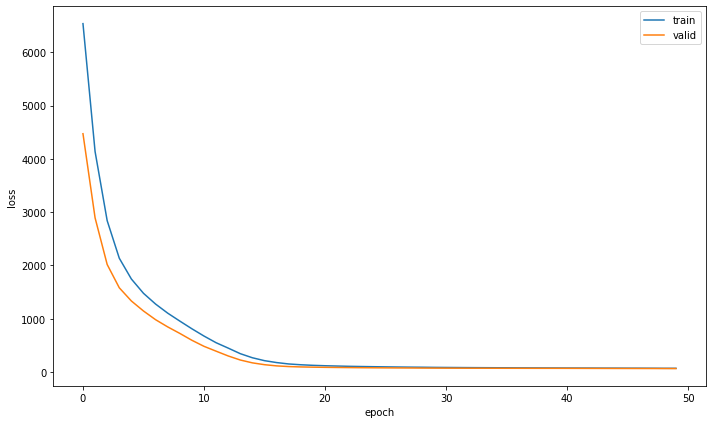

In [56]:
# Plot Loss as a Function of Number of Epoch
model_hist = pd.DataFrame(model.history.history)
plot_model_hist(model_hist)

In [57]:
print('MSE (train):', model.evaluate(X_train, y_train),
      '\nMSE (test):', model.evaluate(X_test, y_test))

MSE (train): 68.26546068784208 
MSE (test): 54.5587840833162


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


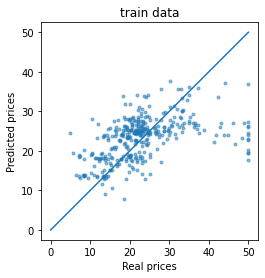

In [58]:
plt.scatter(y_train, model.predict(X_train), marker='.', alpha=0.5)
plt.plot([0,50],[0,50])
plt.title('train data')
plt.xlabel('Real prices')
plt.ylabel('Predicted prices')
plt.gca().set_aspect('equal')

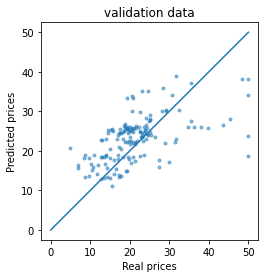

In [59]:
plt.scatter(y_test, model.predict(X_test), marker='.', alpha=0.5)
plt.plot([0,50],[0,50])
plt.title('validation data')
plt.xlabel('Real prices')
plt.ylabel('Predicted prices')
plt.gca().set_aspect('equal')

### SHAP Installation

SHAP can be installed from either PyPI or conda-forge:
##### pip install shap
##### or
##### conda install -c conda-forge shap

In [60]:
!pip install shap

In [61]:
import shap
shap.initjs()

We have trained machine learning model to predict house prices. For a certain house it will predict its  monetary value and you need to explain this prediction. Therefore, we are interested how much has each feature value contributed to the prediction compared to the average prediction.
Although, if model is a deep learning model (and you are working with sequential data), it is advisable to use DeepExplainer. In this example, we will showcase SHAP method applicable to any model- KernelExplainer

*   The Kernel Explainer builds a weighted linear regression by using your data, your predictions, and the function that predicts the predicted values
*   It computes the variable importance values based on the Shapley values from game theory, and the coefficients from a local linear regression



KernelSHAP consists of five steps:



1.   Sample coalitions $z_k′∈ {0,1}^M, k∈{1,…,K}$ (1 = feature present in coalition, 0 = feature absent).
2.   Get prediction for each $z_k′$ by first converting $z_k′$ to the original feature space and then applying model  $\hat{f}:\hat{f}(h_x(z_k′))$
1.   Compute the weight for each $z_k′$ with the SHAP kernel. 
2.  Fit weighted linear model.
1.   Return Shapley values ϕk, the coefficients from the linear mode 



To get from coalitions of feature values to valid data instances, we need a function $h_x(z')=z$  where $h_x: {0,1}^M R^p$. The function  $h_x$  maps 1’s to the corresponding value from the instance x that we want to explain. For tabular data, it maps 0’s to the values of another instance that we sample from the data. This means that we equate “feature value is absent” with “feature value is replaced by random feature value from data”. For tabular data, the following figure visualizes the mapping from coalitions to feature values[14]:

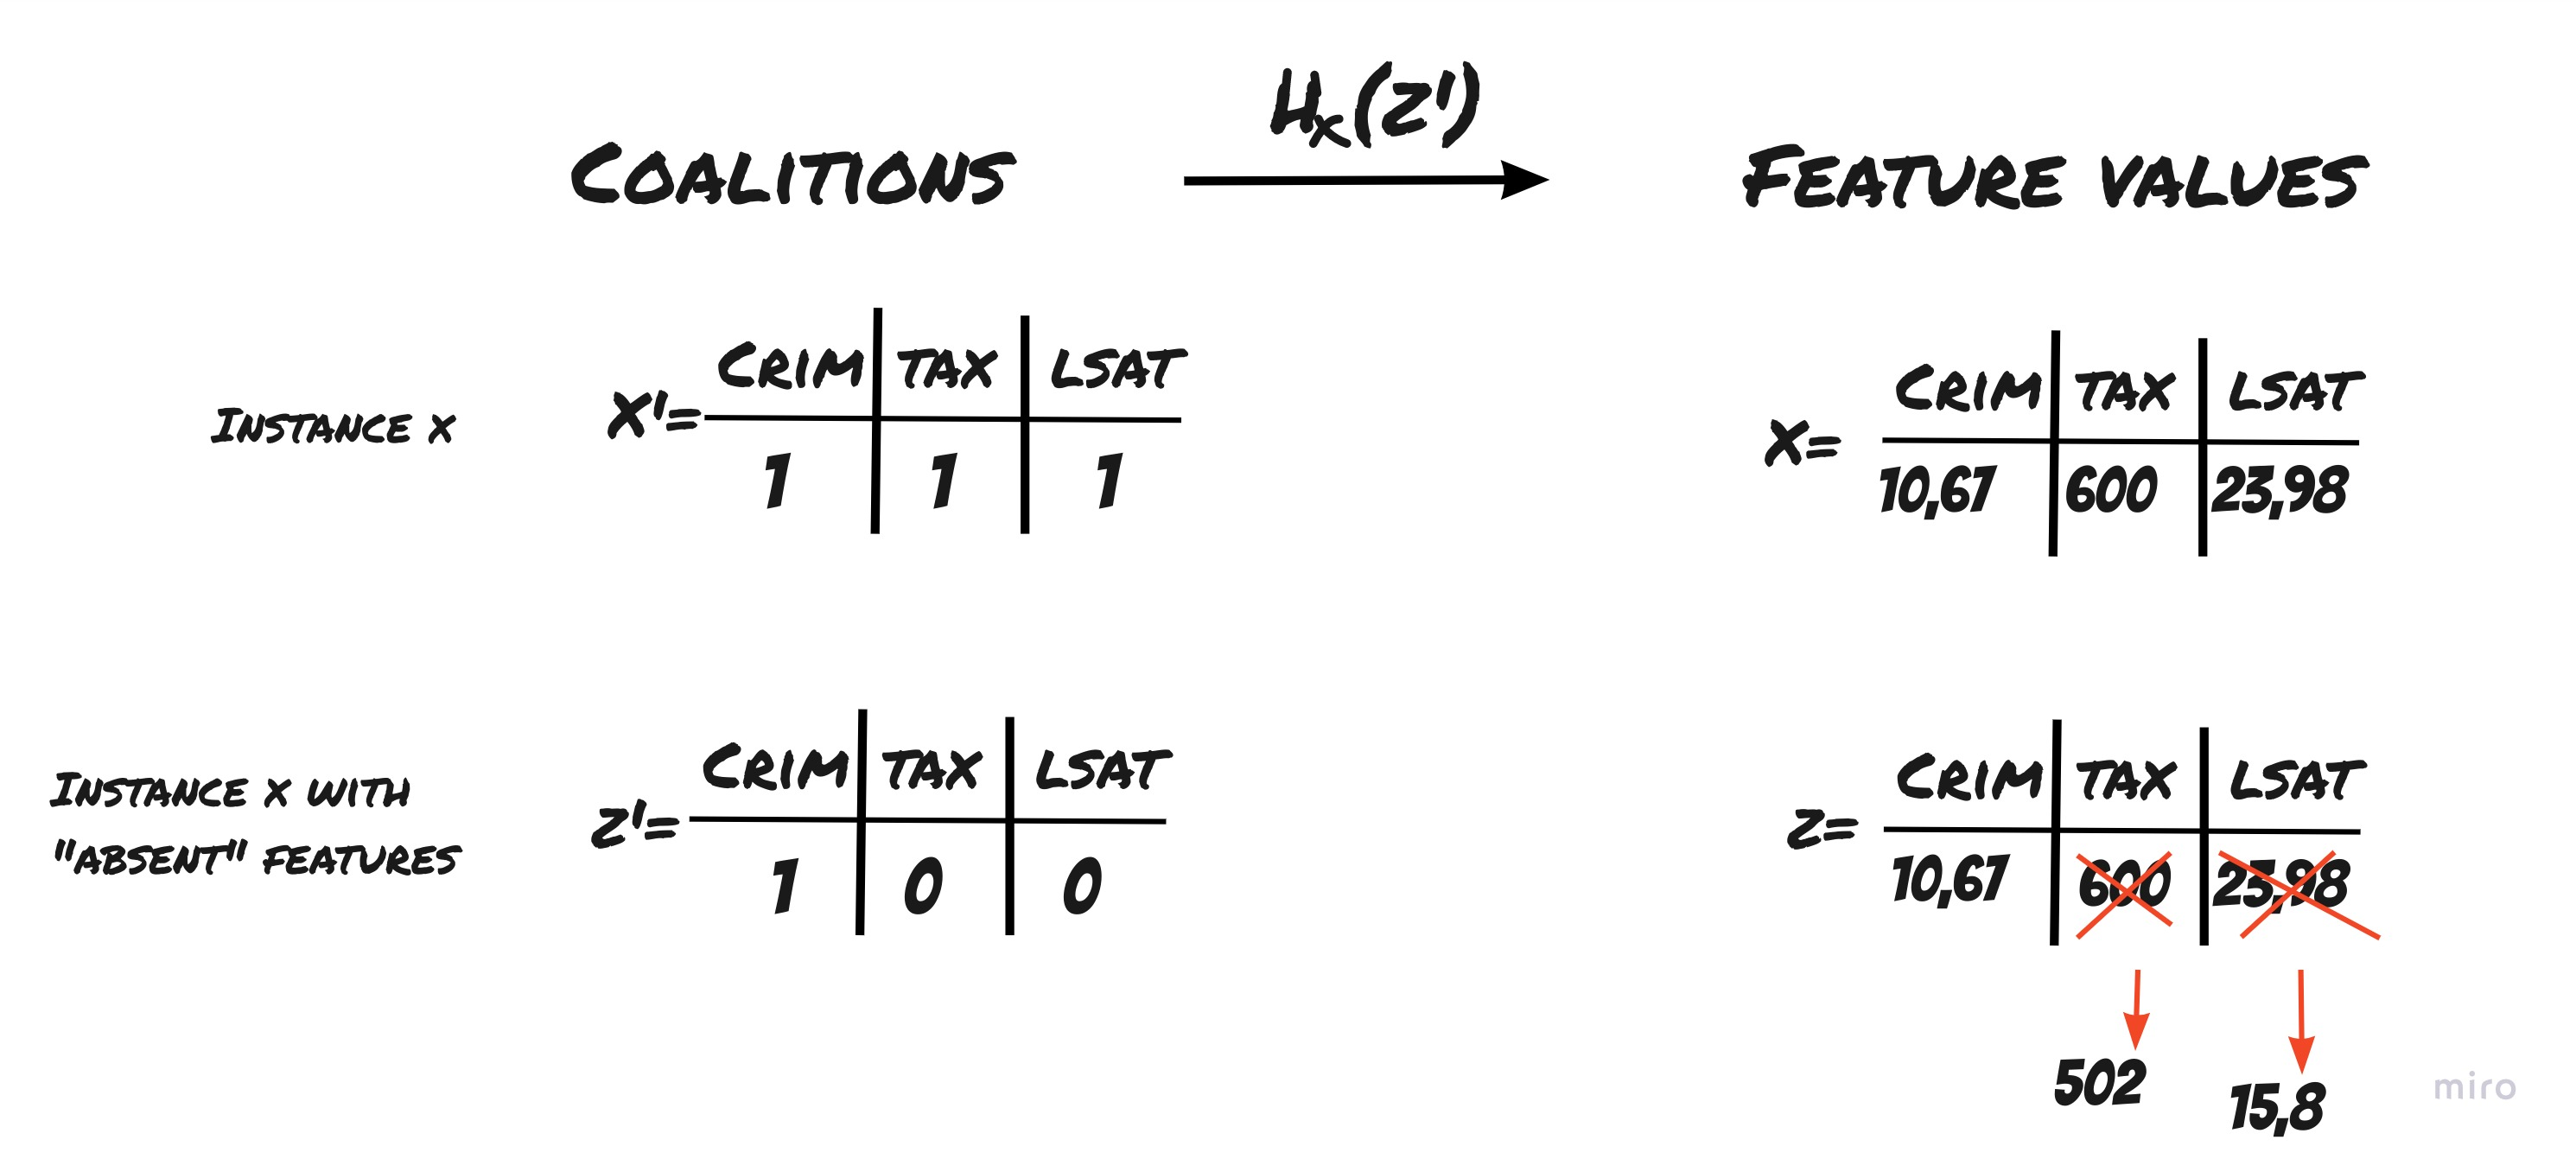


Figure 3: Function $h_x$ maps a coalition to a valid instance. For present features (1),$h_x$ maps to the feature values of x. For absent features (0), $h_x$ maps to the values of a randomly sampled data instance.



hx  for tabular data treats  $X_C$ and $X_S$  as independent and integrates over the marginal distribution[14]:

$\hat{f}(h_x(z'))=E_X(_C)[\hat{f}(x)]$


















In [62]:
# Fix seed for reproducibility
np.random.seed(123)

# Summarize the training set to accelerate analysis
df_train_normed_summary = shap.kmeans(X_train.values, 25)

# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)


# Extract Shapley values from the explainer
shap_values = explainer.shap_values(X_train.values)


  0%|          | 0/354 [00:00<?, ?it/s]

### **SHAP Summary Plot**


*   To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 
*   The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.
*   The color represents the feature value (red high, blue low). [7]






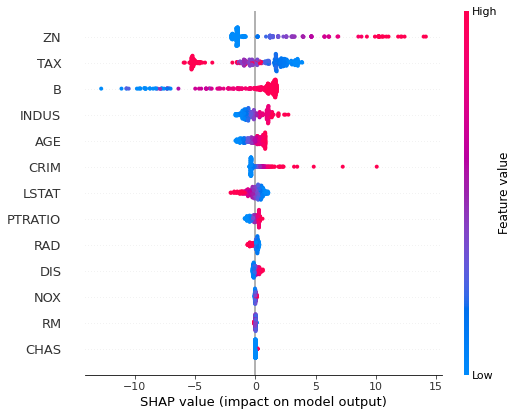

In [63]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], X_train)

*   A summary plot combines feature importance with feature effects. Each point on the summary plot is a shapely value for a feature and an instance.  
*    Feature importance: Variables are ranked in descending order.
*    Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
*    Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
*    Correlation: A high values of the ZN has a high and positive impact on the house price value. The “high” comes from the red color, and the "positive" impact is shown on the X-axis. Similarly, we will say “TAX” is negatively correlated with the target variable.[7]


### **SHAP Waterfall Plot**

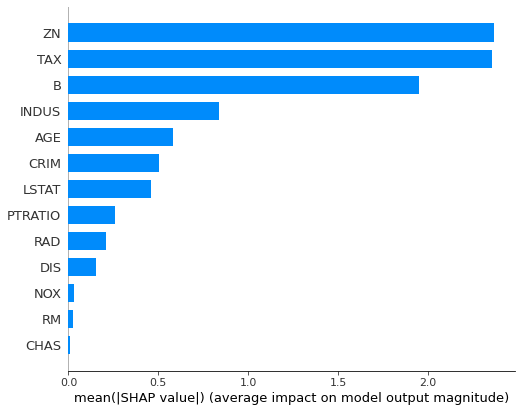

In [64]:
# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot 
# Produces stacked bars for multi-class outputs

shap.summary_plot(shap_values[0], X_train,plot_type='bar')

In [65]:
shap_expl=shap.Explanation(shap_values[0], explainer.expected_value[0],feature_names=X_train.columns)

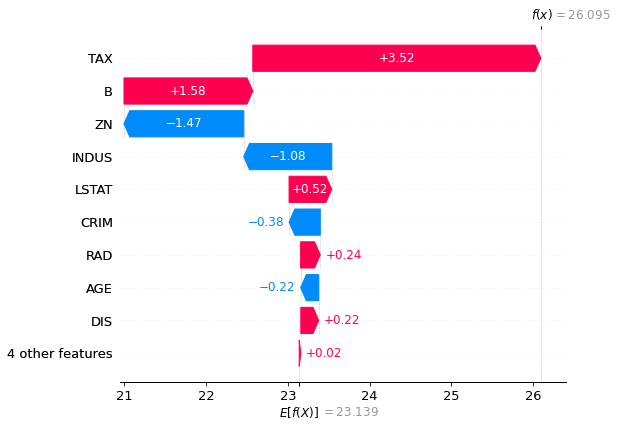

In [66]:
shap.plots.waterfall(shap_expl[0])



*  The SHAP waterfall plots aims to explain how individual price predictions are derived.

*   The Y-axis encodes features and reports the values observed for observation number 0

*   The X-axis encodes the range of our response (house prices)

*   The E[f(X)] = 23.139 at the bottom of the chart is the result from the null model, or the global house price from our dataset



*   The f(x) = 26.095 at the top of the chart is the model prediction for values observed in (1)


Does the ordering of features make an impact on Shapley values?[21]



*   In some cases, the order of features putting into a model plays an essential role in its contribution when there are overlaps amongst the features. For example, when the first feature comes in, it contributes significantly to the model’s performance. The second feature joins later on, and because it has a big overlap with the first feature, the new feature does not add much “new knowledge” to our model. It’s the other way around when we reverse the order. The main idea of Shapley Values is to get the Marginal contributions of a feature in all different orders, then take the average. In other words, we consider the difference in the performance of our model with and without the feature, in all possible ordering.List item




### **SHAP Force Plot**

In [67]:
# Plot the SHAP values for multiple instances
shap.initjs() 
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], X_train.iloc[0:NUM_ROWS])

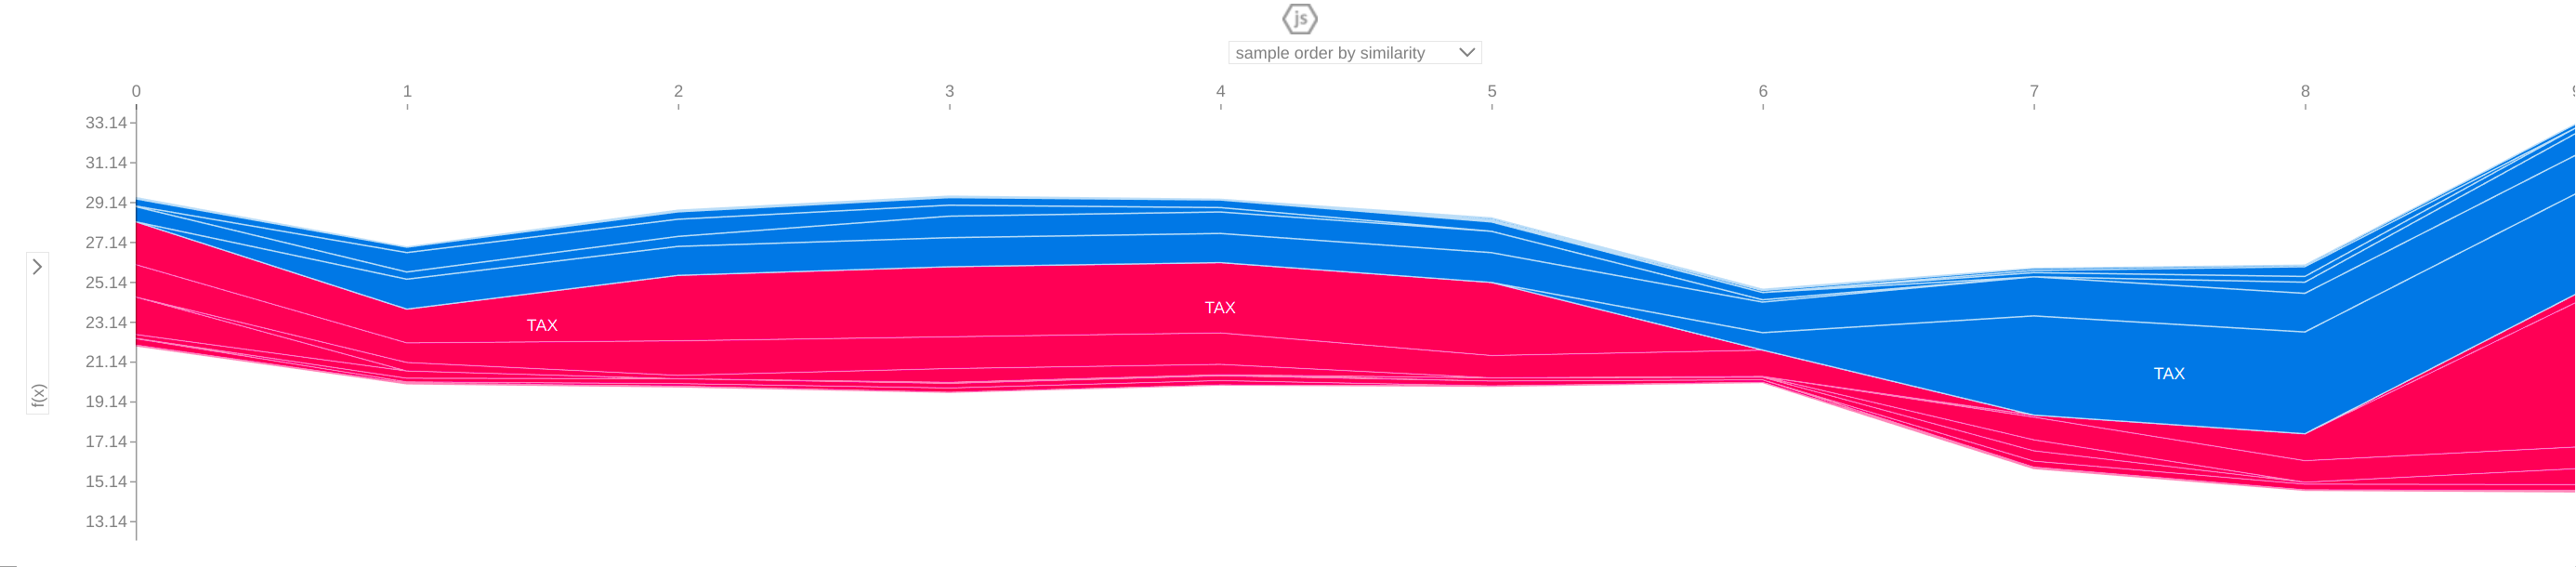

The force plots in the SHAP package can output both local and “global” interpretation graphs. While it does not provide a global explanation in the form of an equation like in our GLMs, it does give us a model-level view of the results to work with [15] This is done by stacking and sorting all the SHAP values for all predictions into 1 plot as shown below.

While both axes can be customized from the combo box, by default, the Y-axis shows the output value of the model, while the X-axis plots all the samples in the dataset sorted by similarity (sorting it by output value is easier to read). Hovering over an area of the graph, provides a quick summary of the significant rating factors that are driving the modelled costs up (in red) or down (in blue).

In [68]:
# Plot the SHAP values for one instance
shap.initjs() 
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], X_train.iloc[INSTANCE_NUM,:])

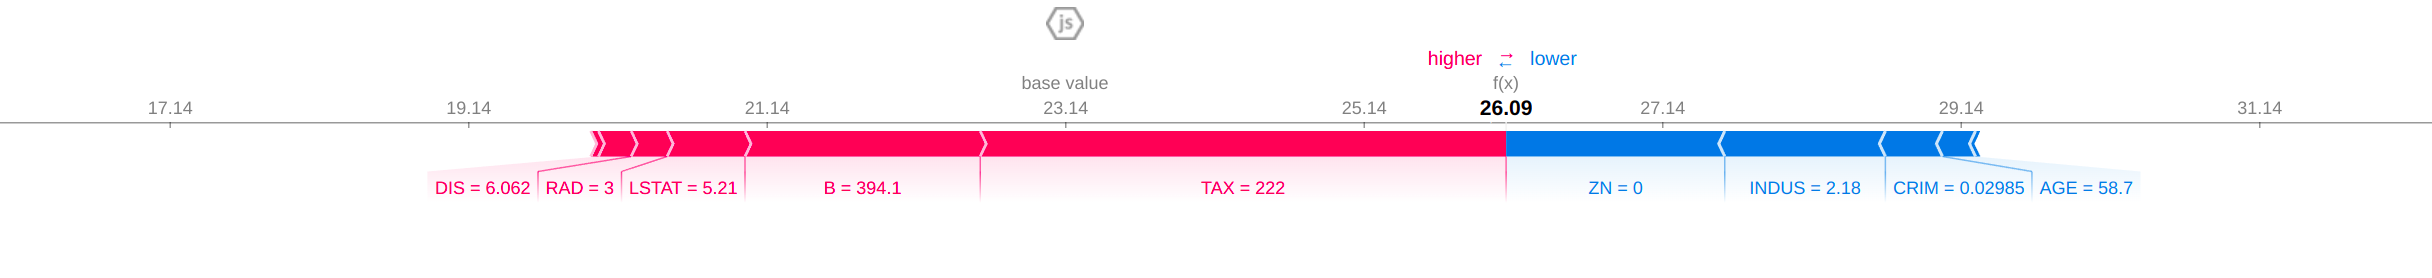


*   Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline, which for shaply values is the average of all the prediction. [7] Let's explain it in detail:
*  *The output value* is the prediction for that observation (the prediction for this observation is **26.09**).
*   *The base value*: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat). You may wonder why it is **23.14**. This is because the mean prediction of Y_test is 23.14. 
*   *Red/blue*: In a force plot, each shapely value is displayed as an arrow that pushes the prediction to increase positive values shown here in red or decrease negative values shown here in blue. 


### **SHAP Dependence Plot**


A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.
*  Each dot is a single prediction (row) from the dataset.
*  The x-axis is the value of the feature (from the X matrix)
*  The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.[1]

The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes downwards says that the higher tax is, the lower weighted distance to five Boston employment centres is (the colour depicts interaction effect of "DIS" feature).



  

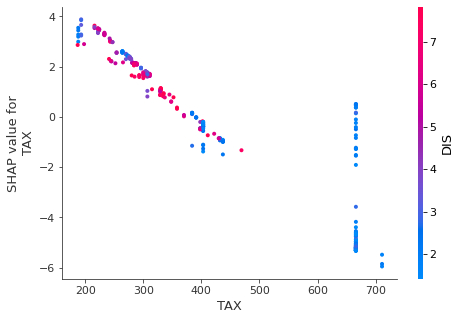

In [69]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('TAX', shap_values[0], X_train, interaction_index='DIS')

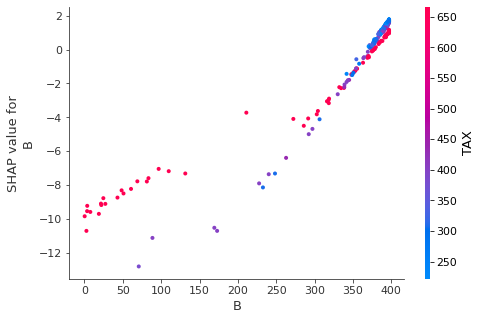

In [70]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('B', shap_values[0], X_train, interaction_index='TAX')

### **SHAP Decision Plot**

*   As like the summary plot, it gives an overall picture of contribution to prediction. From bottom to top of the decision plot, shap values are cumulatively added to the base value of the model in determining the output values.

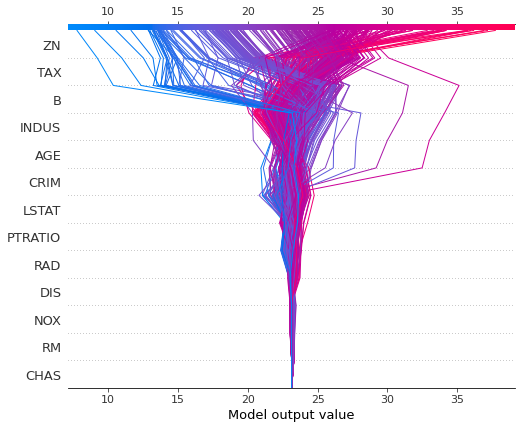

In [71]:
# decision plot for one instance
#shap_expl=shap.Explanation(shap_values[0], explainer.expected_value[0],feature_names=X_train.columns)
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=list(X_train.columns))  

## **Example 2 - MNIST Data Set** 

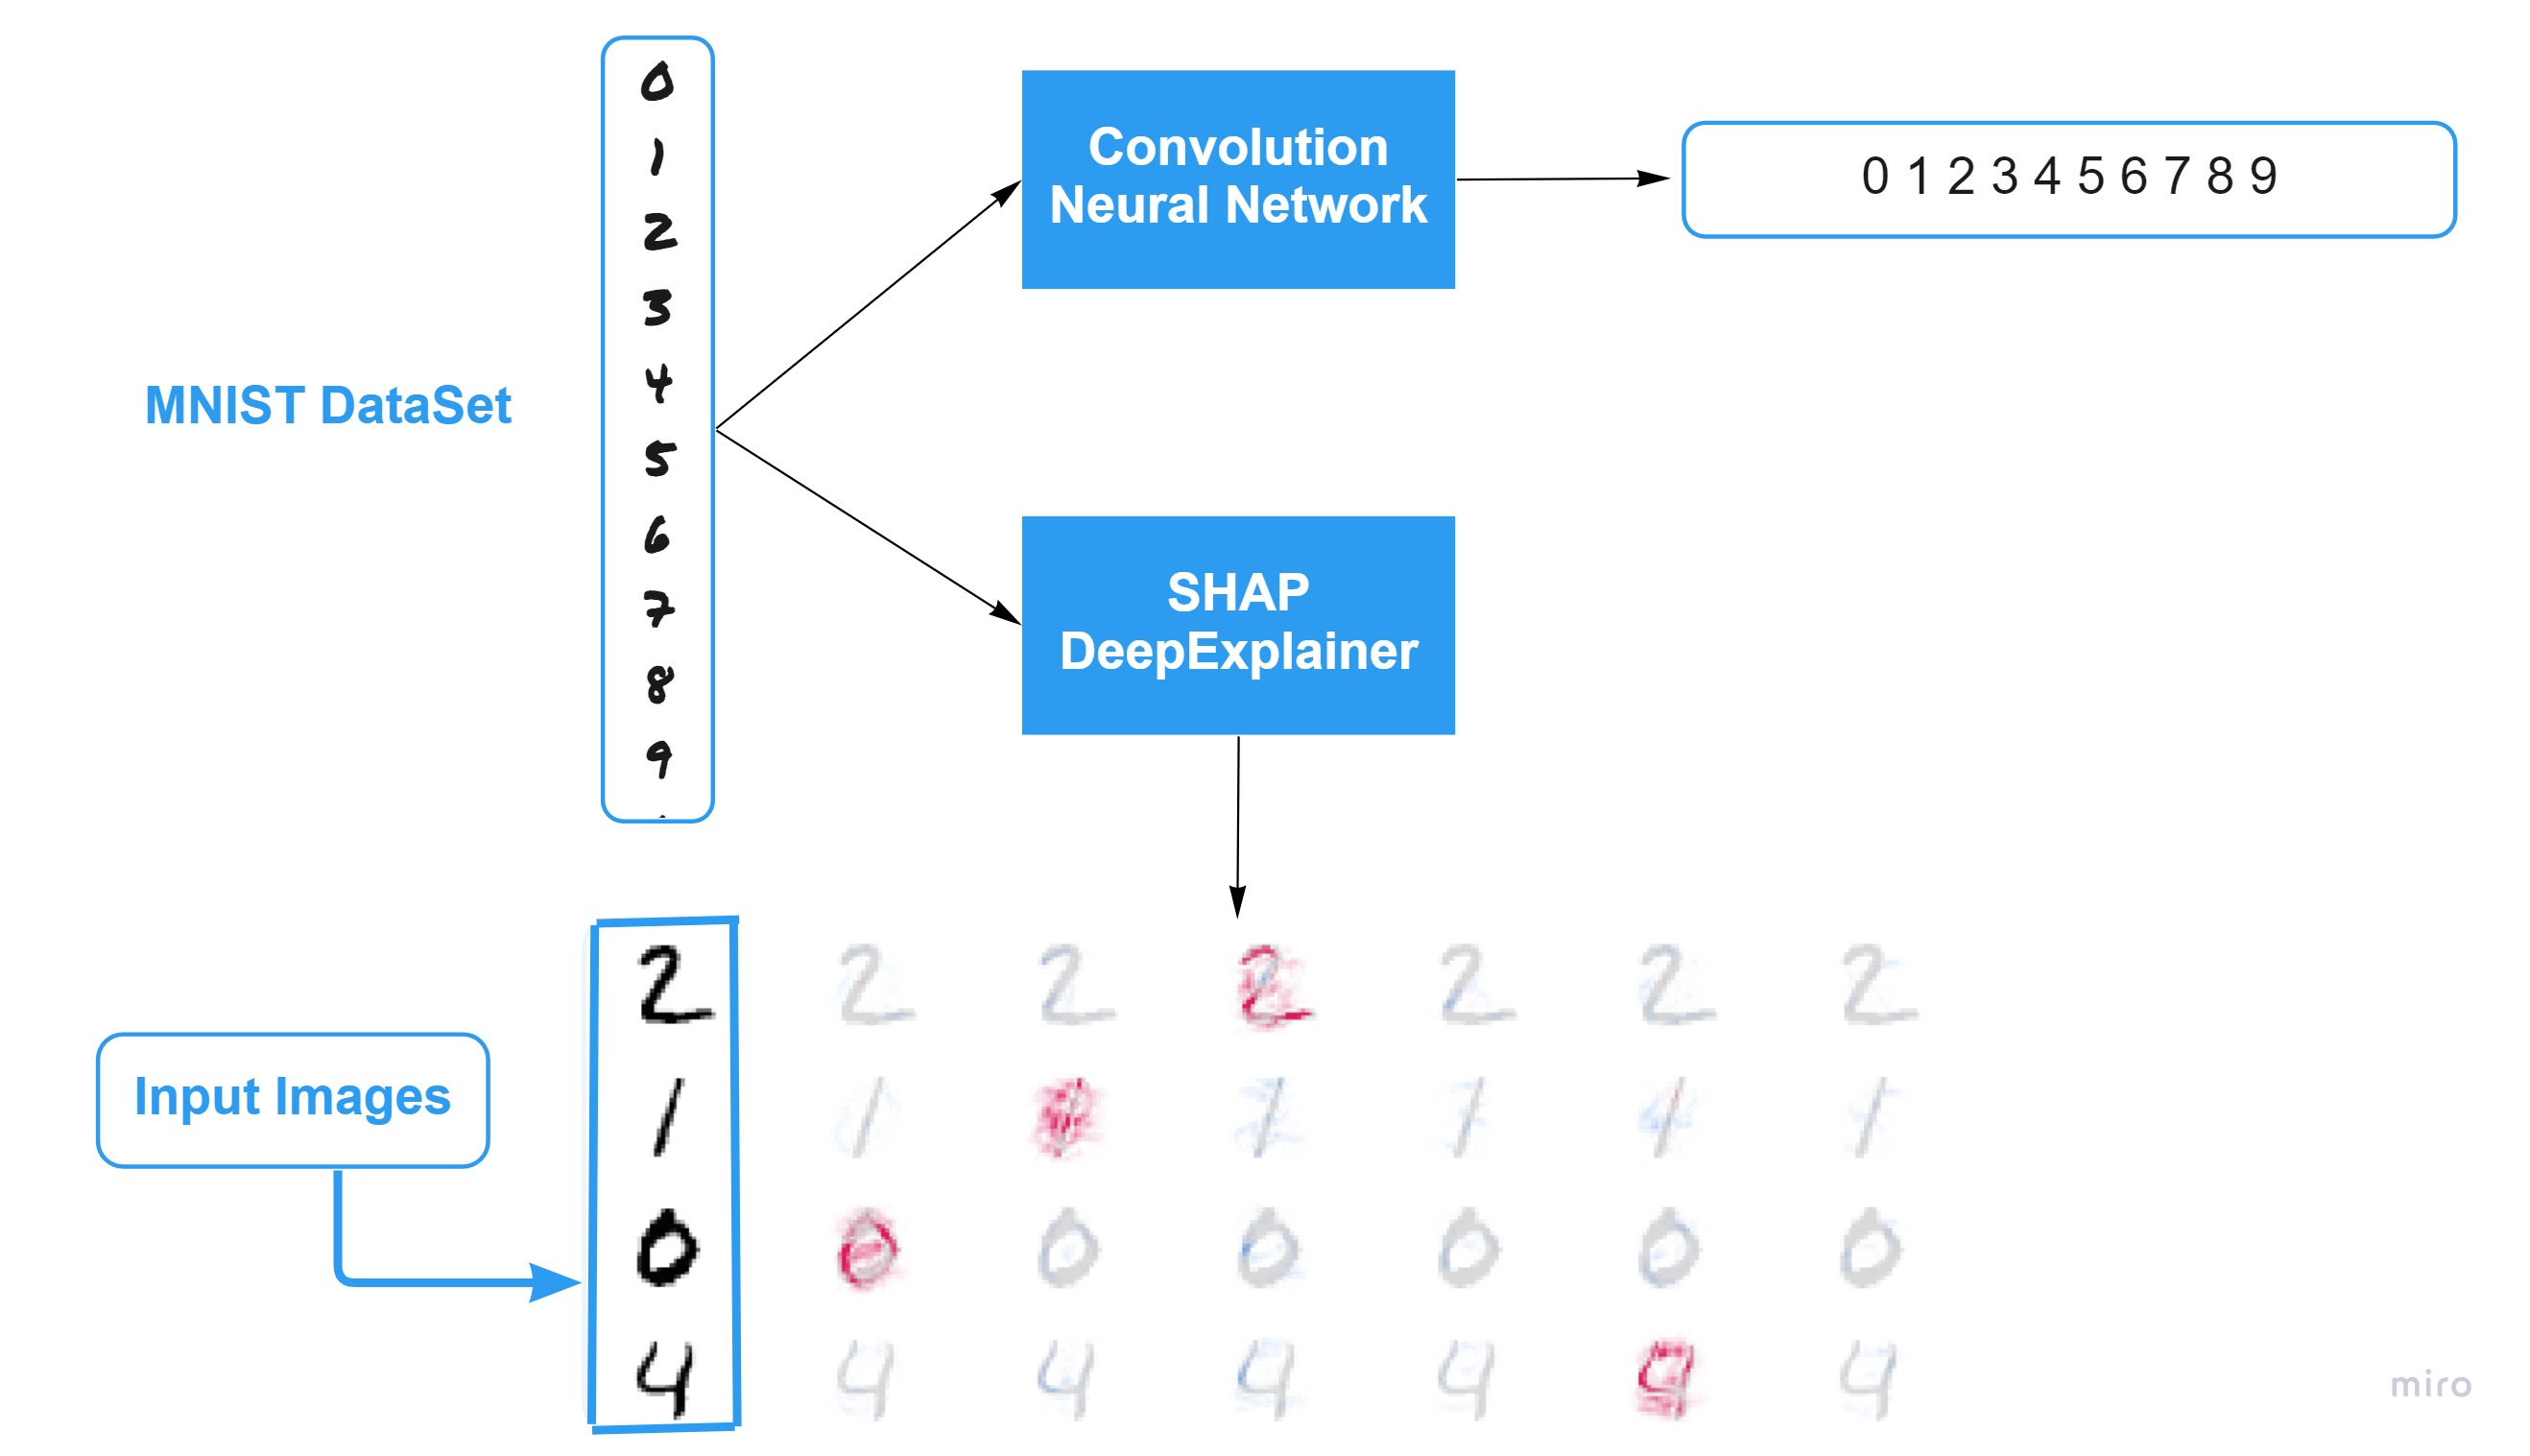

### About the Dataset
We will be working on the MNIST dataset which is a large collection of handwritten digits [20]
* The MNIST dataset contains 60,000 training cases and 10,000 test cases of handwritten digits (0 to 9)[18]
* Each digit is normalized and centered in a gray-scale (0 - 255) image with size 28 × 28
*It is a subset of a larger NIST Special Database 3 (digits written by employees of the United States Census Bureau) and Special Database 1 (digits written by high school students) which contain monochrome images of handwritten digits.

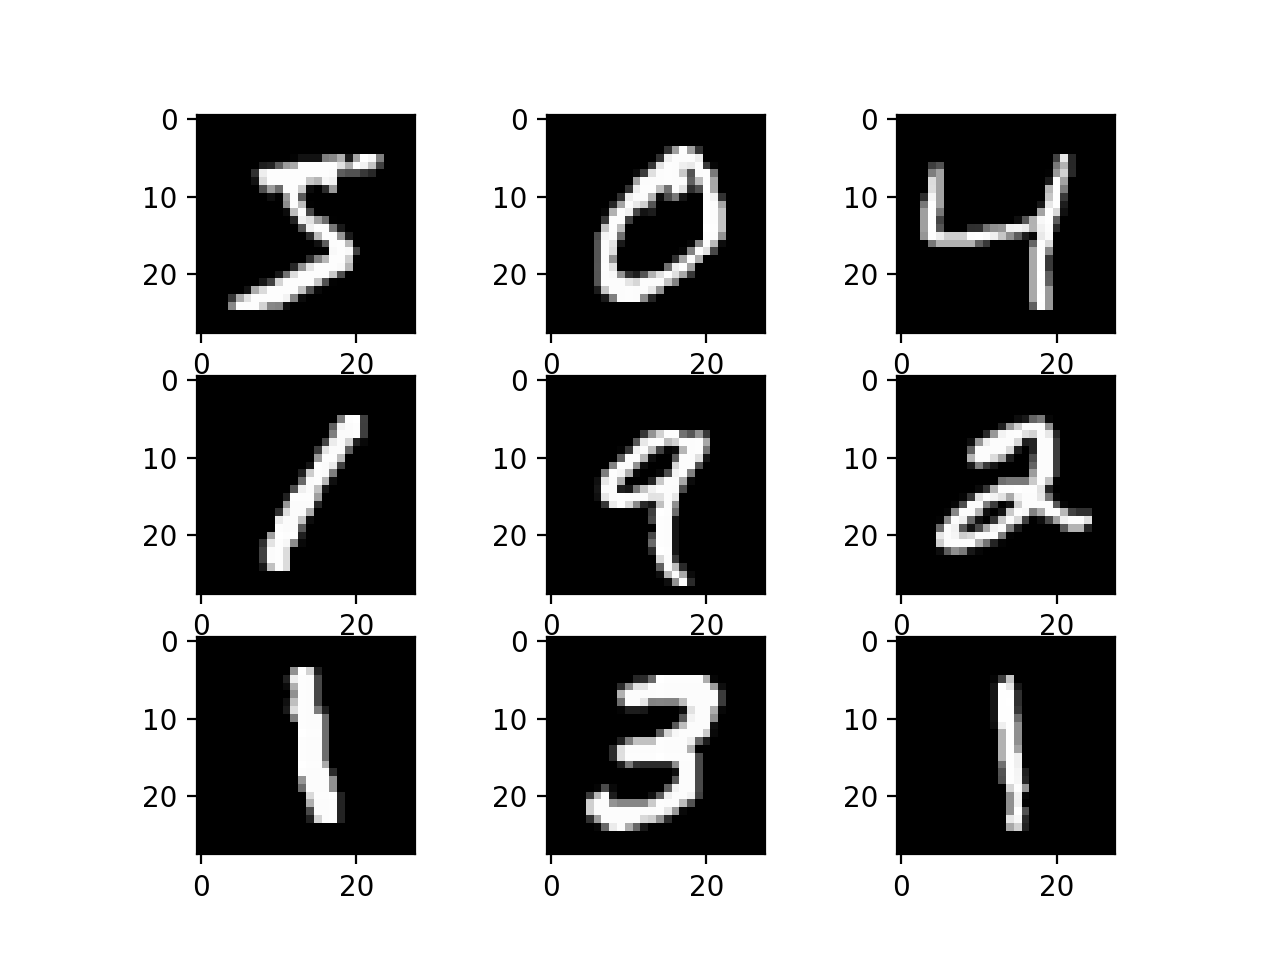

### Importing Libraries

In [72]:
import keras
from keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [73]:
batchsize = 512
total_classes = 10
epochs = 10

### Loading Data

In [74]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

###Data Preparation

In [75]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [76]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [77]:
print(X_train.shape,X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [78]:
Y_train = keras.utils.to_categorical(Y_train, total_classes)
Y_test = keras.utils.to_categorical(Y_test, total_classes)

In [79]:
print(Y_train.shape,Y_test.shape)

(60000, 10) (10000, 10)


###Model Definition

In [80]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
initial = tf.keras.Input(shape=(28, 28, 1))
X = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(initial)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.25)(X, training=True)
X = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(X)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.5)(X, training=True)
X = layers.Flatten()(X)
Final = layers.Dense(total_classes, activation="softmax")(X)
model = tf.keras.Model(inputs=initial, outputs=Final)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                       

### Model Training

In [81]:
history = model.fit(X_train, Y_train, batch_size = batchsize, epochs= 10, validation_split=0.1, shuffle=True)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 33us/sample - loss: 0.7271 - acc: 0.7750 - val_loss: 0.2238 - val_acc: 0.9350
Epoch 2/10


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


54000/54000 [==============================] - 2s 28us/sample - loss: 0.2116 - acc: 0.9356 - val_loss: 0.1277 - val_acc: 0.9663
Epoch 3/10
54000/54000 [==============================] - 2s 29us/sample - loss: 0.1387 - acc: 0.9578 - val_loss: 0.0994 - val_acc: 0.9702
Epoch 4/10
54000/54000 [==============================] - 2s 28us/sample - loss: 0.1105 - acc: 0.9655 - val_loss: 0.0829 - val_acc: 0.9753
Epoch 5/10
54000/54000 [==============================] - 2s 31us/sample - loss: 0.0944 - acc: 0.9706 - val_loss: 0.0746 - val_acc: 0.9790
Epoch 6/10
54000/54000 [==============================] - 2s 34us/sample - loss: 0.0855 - acc: 0.9732 - val_loss: 0.0695 - val_acc: 0.9800
Epoch 7/10
54000/54000 [==============================] - 2s 34us/sample - loss: 0.0769 - acc: 0.9763 - val_loss: 0.0681 - val_acc: 0.9822
Epoch 8/10
54000/54000 [==============================] - 2s 35us/sample - loss: 0.0699 - acc: 0.9778 - val_loss: 0.0628 - val_acc: 0.9828
Epoch 9/10
54000/54000 [==============

In [82]:
Performance = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: ", Performance[1])
print("Test Loss: ", Performance[0])

Test Accuracy:  0.9811
Test Loss:  0.05819934236016124


### SHAP Installation

In [83]:
#installing shap if not installed
!pip install shap

###Interpreting The Model

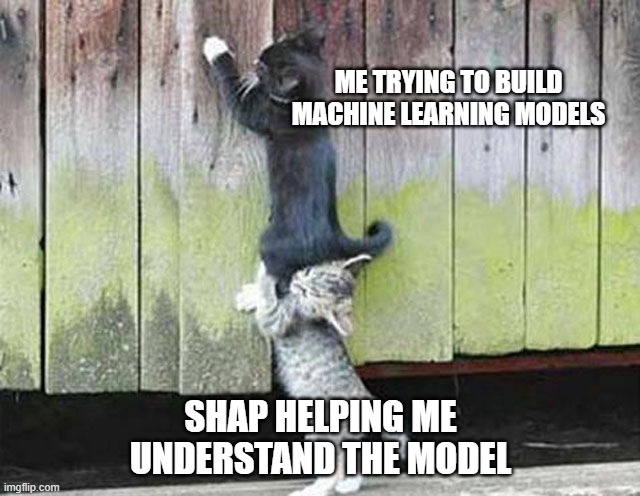

We have trained the model to classify the hand written digits. For an ouput number prediction you need to explain this output. Therefore, we are interested how much has each pixel value contributed to the prediction. We are using DeepExplainer for this purpose.

It can be explained by the scores on each pixel on a predicted image, which indicates how much it contributes to classifying that image into a particular class.


**Deep Explainer** is an enhanced version of the DeepLIFT algorithm similar to Kernel SHAP, we approximate the conditional expectations of SHAP values using a selection of background samples. By integrating over many backgound samples Deep Explainer estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

In [84]:
import shap
#set data samples for expectation
data = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

S1 = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), data)
#calculating SHAP Values
#Return approximate SHAP values for the model applied to the data given by X.
ShapValues = S1.shap_values(X_test[1:20], check_additivity=False)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


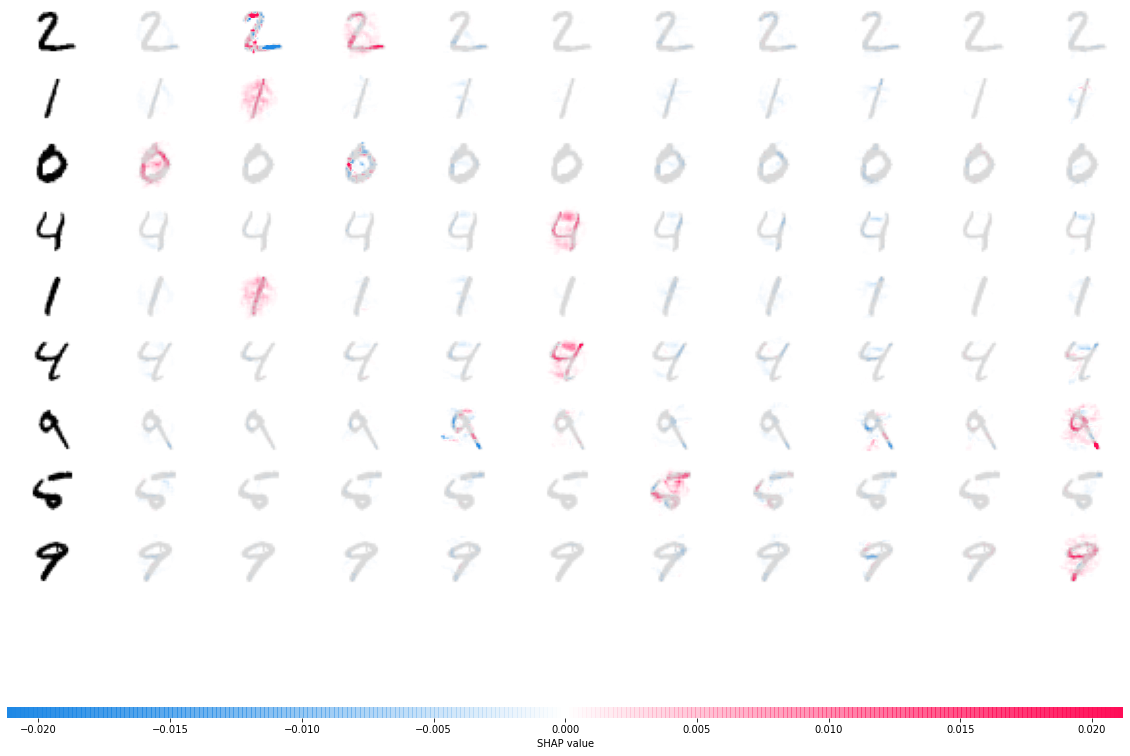

None

In [85]:
#Visualizing Feature importance
Plot = shap.image_plot(ShapValues, -X_test[1:10])
display(Plot)

The plot above demonstrates predictions for 9 images; 2,1,0,4,1,4,9,5,9 

The prediction trend is from left to right. The plot above explains ten outputs (digits 0-9) for nine different images. 

Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left, and as nearly transparent grayscale backings behind each of the explanations. 

The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. 

Some key examples are the following:
- Notice in order to predict number 'Zero', the blank space in the middle is important (You can refer to row 3, column 2)
- For number 'Five' the space between the two junctions make it number 5 instead of number 'Six'
- In order to predict the number 'Four' the space on top makes it a four instead of a nine (row 4, column 6)
- Similarly, we can observe in (row 4, column 11) the blue pixels at the top decreases the output prediction 'four'.



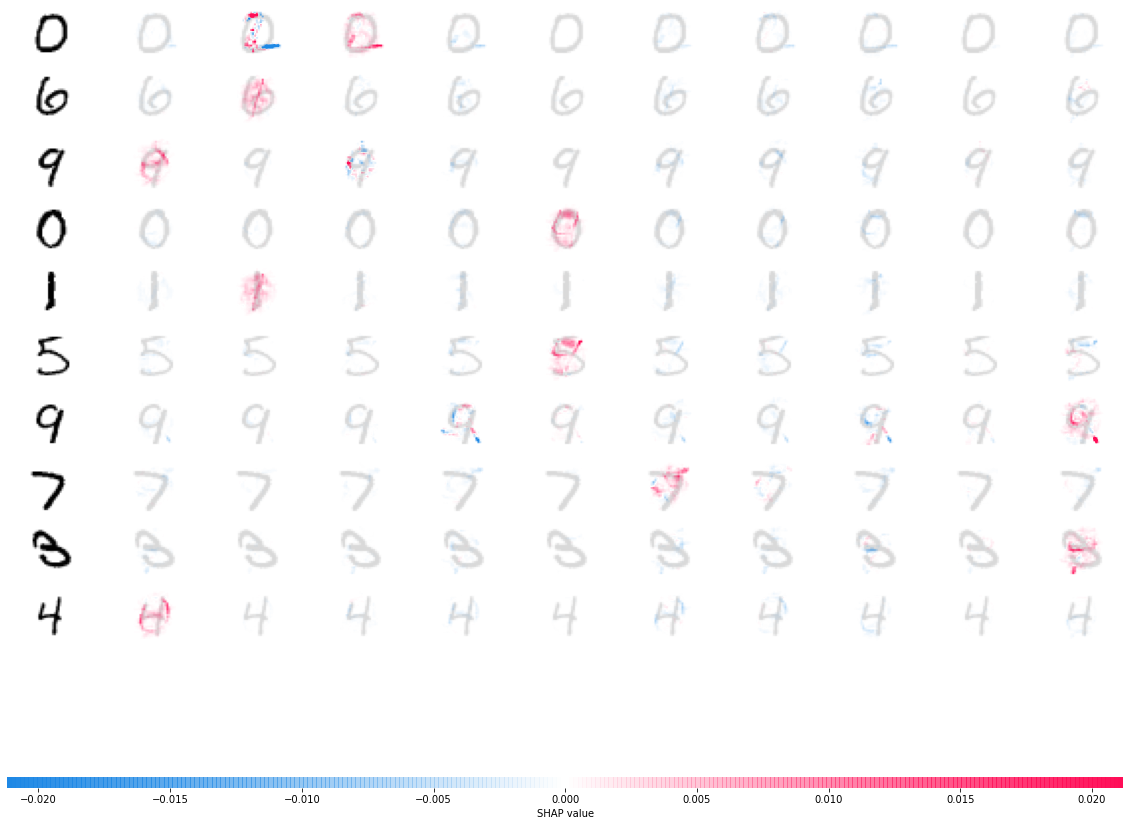

None

In [86]:
#Visualizing Feature importance
Plot = shap.image_plot(ShapValues, -X_test[10:20])
display(Plot)

## **Conclusion**

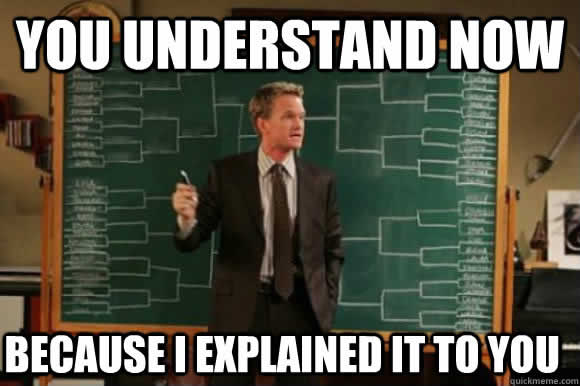

SHAP (SHapley Additive exPlanations) is a game theoretic based explainability method used for interpretation of any machine learning model output by calculating the contribution of each feature to the prediction. With a solid theoretical foundation, SHAP provides an axiomatic way of approaching machine learning explanations. It allows for both local and global reasoning,  enabling exploration of the general behavior of a model and the explanation ("global explanation”) of every single data prediction ("local explanation”). It also supports modeling procedures followed by using libraries like SciKit-Learn, PySpark, TensorFlow, Keras, PyTorch, and many more. 

However, there are several limitations of this explainability method[22]:



*   SHAP only “explains” the variable “correlation” defined per the model structure therefore it is important that each of the variable in the model is individually examined for importance, signage and it causal behaviour
*   SHAP shows sensitivity of the variable to the output global average value — given the model which raises two issues: if the model is incorrectly developed/trained, there would be inherent issues with the SHAP inferences; the incorrectness of benchmark value itself could cause the inference of variables to be wrong — both on the signage and the importance of the feature
*   Since the inference of the SHAP values is strongly related to the “objective” of the model, SHAP output should always be analysed considering the model objective in mind.


## **References**

######  **[1]** Official Github repo: https://github.com/slundberg/shap
######  **[2]** A Unified Approach to Interpreting Model Predictions: https://arxiv.org/pdf/1705.07874v2.pdf
#####   **[3]**  A Novel Approach to Feature Importance — Shapley Additive Explanations: https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b#5280 
######  **[4]** Introduction to Shapley values, https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
######  **[5]** Explain Any Models with the SHAP Values — Use the KernelExplainer: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
######  **[6]** Shapley Additive Explanations (SHAP) for Average Attributions: https://ema.drwhy.ai/shapley.html
######  **[7]** Interpretable Machine Learning,
A Guide for Making Black Box Models Explainable: https://christophm.github.io/interpretable-ml-book/
######  **[8]** Aas, Kjersti et al. “Explaining individual predictions when features are dependent: More accurate approximations to Shapley values.” Artif. Intell. 298 (2021): 103502.
######  **[9]** PyTorch + SHAP = Explainable Convolutional Neural Networks: https://towardsdatascience.com/pytorch-shap-explainable-convolutional-neural-networks-ece5f04c374f
######  **[10]** SHapley Additive exPlanations (SHAP), https://www.coursera.org/lecture/machine-learning-modeling-pipelines-in-production/shapley-additive-explanations-shap-F3NDQ
######  **[11]** Explain Any Models with the SHAP Values — Use the KernelExplainer, https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
######  **[12]** DeepExplainer, https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html
######  **[13]** A Unique Method for Machine Learning Interpretability, Game Theory & Shapley Values: https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/
######  **[14]** KernelExplainer, https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
######  **[15]** Explainable ML: A peek into the black box through SHAP:https://www.actuaries.digital/2021/02/05/explainable-ml-a-peek-into-the-black-box-through-shap/
######  **[16]** Core Explainers: https://shap-lrjball.readthedocs.io/en/latest/api.html#core-explainers
######  **[17]** Boston Housing Dataset, https://www.kaggle.com/c/house-price-prediction-with-boston-housing-dataset
######  **[18]** MNIST dataset, http://yann.lecun.com/exdb/mnist/
######  **[19]** Explain Your Model with the SHAP Values: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
###### **[20]** The Shapley Value for ML Models: https://towardsdatascience.com/the-shapley-value-for-ml-models-f1100bff78d1
###### **[21]** Understanding SHAP for Interpretable Machine Learning: https://ai.plainenglish.io/understanding-shap-for-interpretable-machine-learning-35e8639d03db

###### **[22]** Using SHAP for Explainability — Understand these Limitations First: https://towardsdatascience.com/using-shap-for-explainability-understand-these-limitations-first-1bed91c9d21

